# **1. Import Libraries**

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression
import warnings
warnings.filterwarnings("ignore")

In [ ]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# **2. Load Dataset**

In [32]:
df = pd.read_csv('AmesHousing.csv')

In [33]:
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


# **3. Basic EDA**

In [34]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

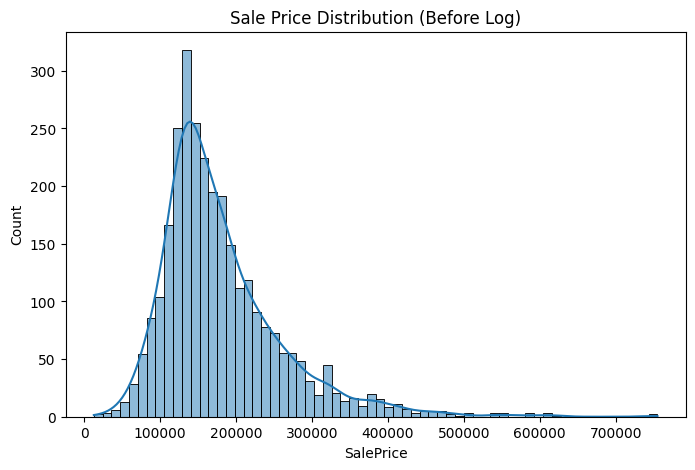

In [35]:
# SalePrice distribution
plt.figure(figsize=(8,5))
sns.histplot(df["SalePrice"], kde=True)
plt.title("Sale Price Distribution (Before Log)")
plt.show()

In [36]:
# Apply log transform on SalePrice
df["SalePrice"] = np.log1p(df["SalePrice"])

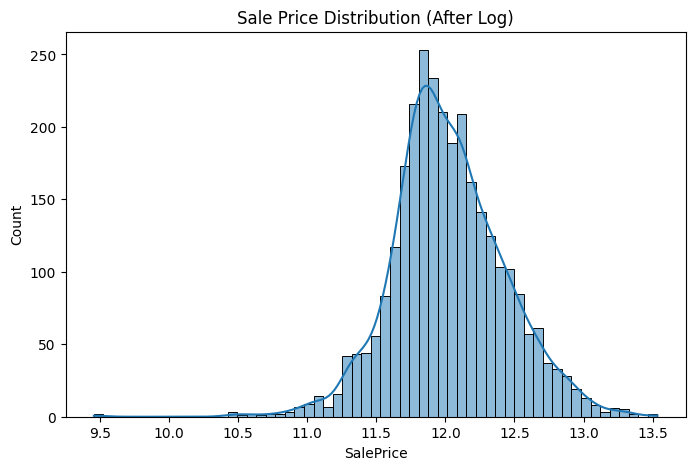

In [37]:
plt.figure(figsize=(8,5))
sns.histplot(df["SalePrice"], kde=True)
plt.title("Sale Price Distribution (After Log)")
plt.show()

# **4. Handle Missing Values**

In [38]:
# Simple Imputer for numerical and categorical
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
cat_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

In [39]:
imputer_num = SimpleImputer(strategy="median")
imputer_cat = SimpleImputer(strategy="most_frequent")

In [40]:
df[num_features] = imputer_num.fit_transform(df[num_features])
df[cat_features] = imputer_cat.fit_transform(df[cat_features])

# **5. Outlier Detection**

In [41]:
# Using Z-score for SalePrice
from scipy import stats
z = np.abs(stats.zscore(df["SalePrice"]))
df = df[z < 3]   # remove outliers > 3 std dev
print("Shape after removing outliers:", df.shape)

Shape after removing outliers: (2910, 82)


# **6. Feature Engineering**

In [42]:
# Encode categoricals (OneHot)
df_encoded = pd.get_dummies(df, drop_first=True)

In [43]:
# Separate features/target
X = df_encoded.drop("SalePrice", axis=1)
y = df_encoded["SalePrice"]

In [44]:
# Feature importance via correlation
corr = df_encoded.corr()["SalePrice"].sort_values(ascending=False)
print("Top correlated features:\n", corr.head(10))

Top correlated features:
 SalePrice         1.000000
Overall Qual      0.819620
Gr Liv Area       0.689957
Garage Cars       0.683008
Garage Area       0.658993
Year Built        0.619918
Total Bsmt SF     0.615660
1st Flr SF        0.593497
Year Remod/Add    0.588419
Full Bath         0.577535
Name: SalePrice, dtype: float64


In [45]:
# Feature importance via mutual information
mi = mutual_info_regression(X, y)
mi = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("Top MI features:\n", mi.head(10))

Top MI features:
 Overall Qual      0.574047
Gr Liv Area       0.479401
Year Built        0.400423
Garage Area       0.390954
Garage Cars       0.387995
Total Bsmt SF     0.382754
1st Flr SF        0.356930
Garage Yr Blt     0.320444
MS SubClass       0.285487
Year Remod/Add    0.275632
dtype: float64


# **7. Train/Test Split**

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# Scale numerical features
scaler = StandardScaler()
num_features.remove('SalePrice')
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

# **8. Cross-Validation**

In [48]:
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(max_depth=10, random_state=42)
}

In [49]:
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="r2")
    print(f"\n{name} - CV R2 Mean: {scores.mean():.4f} | Std: {scores.std():.4f}")


LinearRegression - CV R2 Mean: 0.8651 | Std: 0.0523

DecisionTree - CV R2 Mean: 0.7787 | Std: 0.0262


# **9. Hyperparameter Tuning for Decision Tree**

In [50]:
param_grid = {
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}


In [51]:
grid = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid,
                    cv=5, scoring="r2", n_jobs=-1, verbose=1)

In [52]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='r2', verbose=1)

In [53]:
print("\nBest Decision Tree Params:", grid.best_params_)
print("Best CV R2 Score:", grid.best_score_)


Best Decision Tree Params: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best CV R2 Score: 0.8084308698773972


In [54]:
best_tree = grid.best_estimator_

# **10. Final Evaluation on Test Set**

In [55]:
final_models = {
    "LinearRegression": LinearRegression().fit(X_train, y_train),
    "BestDecisionTree": best_tree
}

In [56]:
results = []
for name, model in final_models.items():
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})

results_df = pd.DataFrame(results)
print("\nFinal Test Results:\n", results_df)


Final Test Results:
               Model       MAE      RMSE        R2
0  LinearRegression  0.080192  0.150352  0.837245
1  BestDecisionTree  0.119775  0.172058  0.786860


# **11. Residual Analysis (Linear Regression)**

In [57]:
lin_preds = final_models["LinearRegression"].predict(X_test)
residuals = y_test - lin_preds

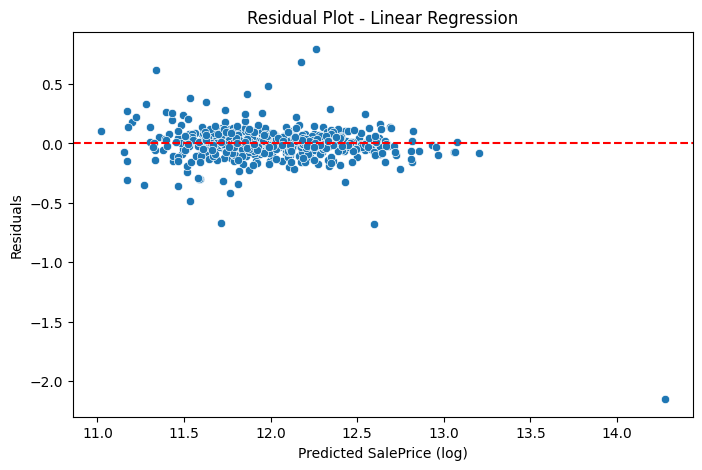

In [58]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=lin_preds, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted SalePrice (log)")
plt.ylabel("Residuals")
plt.title("Residual Plot - Linear Regression")
plt.show()

# **12. Feature Importance (Decision Tree)**

In [59]:
feat_importance = pd.Series(best_tree.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)

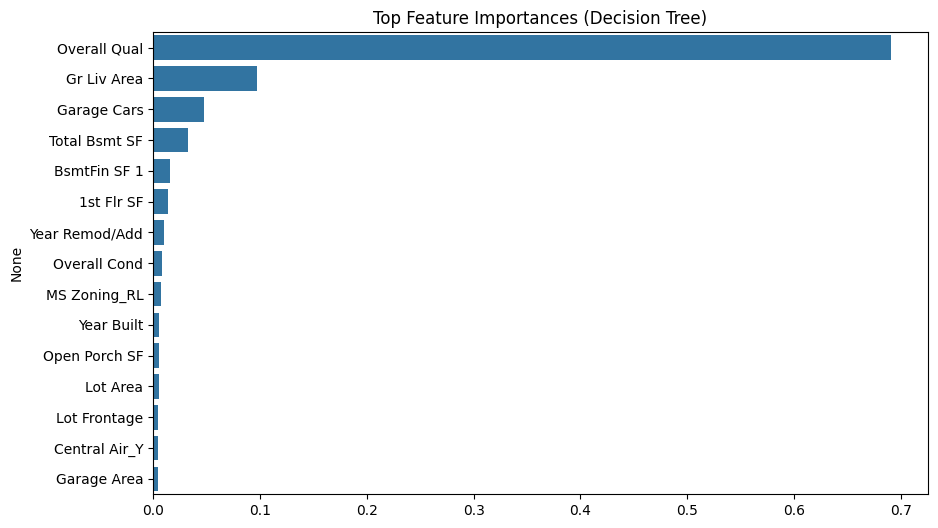

In [60]:
plt.figure(figsize=(10,6))
sns.barplot(x=feat_importance.values, y=feat_importance.index)
plt.title("Top Feature Importances (Decision Tree)")
plt.show()

# **13. Markdown Comparison Table**

In [62]:
md_table = "| Model | MAE | RMSE | R² |\n"
md_table += "|-------|------|------|------|\n"

for _, row in results_df.iterrows():
    md_table += f"| {row['Model']} | {row['MAE']:.4f} | {row['RMSE']:.4f} | {row['R2']:.4f} |\n"

display(Markdown("### 📊 Final Model Comparison\n" + md_table))


### 📊 Final Model Comparison
| Model | MAE | RMSE | R² |
|-------|------|------|------|
| LinearRegression | 0.0802 | 0.1504 | 0.8372 |
| BestDecisionTree | 0.1198 | 0.1721 | 0.7869 |
